<a href="https://colab.research.google.com/github/julianavmgiusti/tcc_soulcode/blob/tcc_soulcode/projeto_final_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto Final - SoulCode AD1**

##Sobre os DataSets

---

**Contexto**

*Nesse documento vamos estar fazendo o ETL dos datasets utilizados no projeto final do Grupo 2 do BootCamp de Analise de Dados da SoulCode. O assunto escolhido foi Mercado do café no Brasil e suas ramificações.*

**Informações sobre os atributos**

*Teremos diversos datasets sendo tratados nesse documento, cada qual terá seus atributos devidamente descritos no momento do tratamento.*

**Armazenamento dos DataSets:** *Todos os DataSets aqui tratados estaram em um bucket do Google Cloud Services*

##About the Analisys

---

**Contexto**
  
**


##Tech Requirements

---

Installing the Requirements

---

In [ ]:
pip install pandera #Pandera, for data-validation

In [ ]:
pip install gcsfs #Google Cloud Storage File System

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyspark #PySpark for large chunks of Data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install --upgrade pandas #Upgrading pandas to 2.X

In [ ]:
pip install openpyxl

In [ ]:
pip install pymongo

Importing Libraries

---


In [ ]:
import pandas as pd
import numpy as np
#import pandera as pa
import matplotlib.pyplot as plt
import seaborn as snb
from google.cloud import storage
import os
import warnings                                         #To avoid any warnings
warnings.filterwarnings("ignore")
#import pymongo
#from pymongo import MongoClient

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [ ]:
from openpyxl import Workbook

In [ ]:
from datetime import datetime

In [ ]:
import re

In [ ]:
import locale

Pandas Config

---


In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 30)

Cloud Storage Config

---

In [ ]:
serviceAccount = '/content/projeto-final-comercio-2afbd13ce6d4.json' #credential here
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

client_gcloud = storage.Client()
bucket = client_gcloud.get_bucket('comercio-cafe') #bucket here

**Conexão com MongoDB**


---



In [ ]:
uri = "mongodb+srv://clustersoulcode.zhu5xkm.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/X509-cert-2285499410270056619.pem',
                     )

In [ ]:
spark = (SparkSession.builder
                     .master('local[2]')
                     .appName('coffee_brasil')
                     .config('spark.ui.port', '4050')
                     .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                     .getOrCreate()
)

#Dados do Ministério do Turismo
---

EXTRAÇÃO

In [ ]:
df = pd.read_csv('gs://comercio-cafe/BRUTOS/Ministério do Turismo/restaurante-cafeteria-bar-e-similares (1).csv', sep = ';', encoding='ISO-8859-1')

##Pre-Análise
---

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20398 entries, 0 to 20397
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Número de Inscrição do CNPJ        20398 non-null  object
 1   Nome da Pessoa Jurídica            20398 non-null  object
 2   Nome Fantasia                      20398 non-null  object
 3   Situação Cadastral                 20398 non-null  object
 4   Situação da Atividade              20398 non-null  object
 5   Tipo de Estabelecimento            20398 non-null  object
 6   Natureza Jurídica                  20398 non-null  object
 7   Porte                              20398 non-null  object
 8   Endereço Completo Receita Federal  20398 non-null  object
 9   UF                                 20398 non-null  object
 10  Município                          20398 non-null  object
 11  Data de Abertura                   20398 non-null  object
 12  CNAE

In [ ]:
df.head()

,Número de Inscrição do CNPJ,Nome da Pessoa Jurídica,Nome Fantasia,Situação Cadastral,Situação da Atividade,Tipo de Estabelecimento,Natureza Jurídica,Porte,Endereço Completo Receita Federal,UF,Município,Data de Abertura,CNAE(S) relacionados à atividade,Endereço Completo Comercial,Telefone Comercial,E-mail Comercial,Website,Número do Certificado,Validade do Certificado,Tipo,Especialidade,Idiomas
0,17.555.508/0001-59,ROVERETO PIZZA NA PEDRA EIRELI,REVERETO PIZZA NA PEDRA,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,MICROEMPRESA,13 LOTE 04 LOJA 08 E 09 Bra...,DF,Brasília,05/02/2013,5611201|5611203,13 Brasília Norte (Águas Claras) CEP: 7190972...,(61)3381-7919,contato@rovereto.com.br,-,17.555.508/0001-59,18/08/2023,Restaurante,Brasileira,-
1,10.533.528/0001-80,TLPS COMERCIO DE ALIMENTOS LTDA,TLPS COMERCIO DE ALIMENTOS LTDA,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,CONJUNTO NACIONAL Brasília,DF,Brasília,01/12/2008,5611201,Conjunto Nacional Brasília Brasília Asa Norte...,-,RUSHFC@HOTMAIL.COM,-,10.533.528/0001-80,15/09/2023,Restaurante,Italiana,Inglês
2,22.443.265/0001-05,PANELINHAS DO BRASIL COZINHA E RESTAURANTE JK ...,PANELINHA DO BRASIL JK SHOPPING,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,QNM 34 Área Especial 1 : 3 PISO PAVMTO: 2 LO...,DF,Brasília,16/04/2015,5620101|5611201,QNM 34 Área Especial 1 Brasília Taguatinga No...,(61)9982-5745,wellington@markaempreendimento.com.br,-,22.443.265/0001-05,17/09/2023,Restaurante,Brasileira,Inglês
3,20.058.922/0001-67,PBG RESTAURANTE EIRELI,RESTAURANTE 209 SUL,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,EMPRESA DE PEQUENO PORTE,CLS 209 Bloco A LOJA: 37 Brasília Asa Sul CEP...,DF,Brasília,08/04/2014,5611201|5611204,CLS 209 Bloco A Brasília Asa Sul CEP: 7027251...,(61)8161-1359,paulobenite@gmail.com,-,20.058.922/0001-67,29/11/2023,Restaurante,Brasileira,-
4,15.288.016/0001-19,CAFE SHOPPING COMERCIO DE ALIMENTOS EIRELI,FRANS CAFE,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,EMPRESA DE PEQUENO PORTE,1 SUBSOLO Brasília,DF,Brasília,12/03/2012,5611203|5611204,Brasília Shopping and Towers Brasília Asa Nor...,(61)2109-2101,nadia.oliveira@brasiliashopping.com.br,-,15.288.016/0001-19,25/08/2023,Similar,Americana,Inglês


In [ ]:
df.isna().sum()

Número de Inscrição do CNPJ           0
Nome da Pessoa Jurídica               0
Nome Fantasia                         0
Situação Cadastral                    0
Situação da Atividade                 0
Tipo de Estabelecimento               0
Natureza Jurídica                     0
Porte                                 0
Endereço Completo Receita Federal     0
UF                                    0
Município                             0
Data de Abertura                      0
CNAE(S) relacionados à atividade      0
Endereço Completo Comercial           0
Telefone Comercial                    0
E-mail Comercial                      0
Website                              97
Número do Certificado                 0
Validade do Certificado               0
Tipo                                  0
Especialidade                         0
Idiomas                               0
dtype: int64

In [ ]:
df['cnpj'].nunique()

In [ ]:
df['tipo'].unique()

## Transformação
Aqui os dados extraídos precisam ser transformados em um formato adequado para análise, e para isso deve seguir alguns passos, que podem precisar serem repetidos ao longo do processo de análise.

In [ ]:
df['data_abertura'] = df['data_abertura'].astype(str)
df['data_abertura'] = pd.to_datetime(df['data_abertura'], dayfirst=True)

df['val_certificado'] = df['val_certificado'].astype(str)
df['val_certificado'] = pd.to_datetime(df['val_certificado'], dayfirst=True)

### Limpeza de Dados
Remover dados duplicados, corrigir erros de digitação, tratar dados inconsistentes etc.

In [ ]:
df.drop(columns={'tel_comercial',
                 'email_comercial',
                 'num_certificado',
                 'end_rf',
                 'pj'}, inplace=True)

In [ ]:
df.drop(columns={'website'}, inplace=True)

### Normalização de Dados
Colocar os dados em um formato padronizado para facilitar a análise.

In [ ]:
df.rename(columns={'Número de Inscrição do CNPJ':'cnpj',
                   'Nome da Pessoa Jurídica':'pj',
                   'Nome Fantasia':'nome_fantasia',
                   'Situação Cadastral':'sit_cadastral',
                   'Situação da Atividade':'sit_atividade',
                   'Tipo de Estabelecimento':'tipo_estabecimento',
                   'Natureza Jurídica':'nat_juridica',
                   'Porte':'porte',
                   'Endereço Completo Receita Federal':'end_rf',
                   'UF':'uf',
                   'Município':'minicipio',
                   'Data de Abertura':'data_abertura',
                   'CNAE(S) relacionados à atividade':'cnaes',
                   'Endereço Completo Comercial':'end_comercial',
                   'Telefone Comercial':'tel_comercial',
                   'E-mail Comercial':'email_comercial',
                   'Website':'website',
                   'Número do Certificado':'num_certificado',
                   'Validade do Certificado':'val_certificado',
                   'Tipo':'tipo',
                   'Especialidade':'especialidade',
                   'Idiomas':'idiomas'}, inplace=True)

In [ ]:
schema = pa.DataFrameSchema(
    columns = {
        'cnpj':pa.Column(pa.String, nullable=False),
        'nome_fantasia':pa.Column(pa.String, nullable=False),
        'sit_cadastral':pa.Column(pa.String, nullable=False),
        'sit_atividade':pa.Column(pa.String, nullable=False),
        'tipo_estabecimento':pa.Column(pa.String, nullable=False),
        'nat_juridica':pa.Column(pa.String, nullable=False),
        'porte':pa.Column(pa.String, nullable=False),
        'uf':pa.Column(pa.String, nullable=False),
        'minicipio':pa.Column(pa.String, nullable=False),
        'data_abertura':pa.Column(pa.DateTime, nullable=False),
        'cnaes':pa.Column(pa.String, nullable=False),
        'end_comercial':pa.Column(pa.String, nullable=False),
        'val_certificado':pa.Column(pa.DateTime, nullable=False),
        'tipo':pa.Column(pa.String, nullable=False),
        'especialidade':pa.Column(pa.String, nullable=False),
        'idiomas':pa.Column(pa.String, nullable=False)

})

schema.validate(df)

,cnpj,nome_fantasia,sit_cadastral,sit_atividade,tipo_estabecimento,nat_juridica,porte,uf,minicipio,data_abertura,cnaes,end_comercial,val_certificado,tipo,especialidade,idiomas
0,17.555.508/0001-59,REVERETO PIZZA NA PEDRA,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,MICROEMPRESA,DF,Brasília,2013-05-02,5611201|5611203,13 Brasília Norte (Águas Claras) CEP: 7190972...,2023-08-18,Restaurante,Brasileira,-
1,10.533.528/0001-80,TLPS COMERCIO DE ALIMENTOS LTDA,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,DF,Brasília,2008-01-12,5611201,Conjunto Nacional Brasília Brasília Asa Norte...,2023-09-15,Restaurante,Italiana,Inglês
2,22.443.265/0001-05,PANELINHA DO BRASIL JK SHOPPING,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,DF,Brasília,2015-04-16,5620101|5611201,QNM 34 Área Especial 1 Brasília Taguatinga No...,2023-09-17,Restaurante,Brasileira,Inglês
3,20.058.922/0001-67,RESTAURANTE 209 SUL,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,EMPRESA DE PEQUENO PORTE,DF,Brasília,2014-08-04,5611201|5611204,CLS 209 Bloco A Brasília Asa Sul CEP: 7027251...,2023-11-29,Restaurante,Brasileira,-
4,15.288.016/0001-19,FRANS CAFE,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,EMPRESA DE PEQUENO PORTE,DF,Brasília,2012-12-03,5611203|5611204,Brasília Shopping and Towers Brasília Asa Nor...,2023-08-25,Similar,Americana,Inglês
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20393,08.017.496/0002-07,BRÁZ PIZZARIA,Regular,Operação,Filial,Sociedade Empresária Limitada,DEMAIS,RJ,Rio de Janeiro,2009-02-16,5620102|9001999|5611201|5611203,Érico Veríssimo 46 Rio de Janeiro Barra da Tij...,2024-03-31,Restaurante,Italiana,-
20394,02.526.318/0001-36,N A ESPETINHOS,Regular,Operação,Matriz,Sociedade Empresária Limitada,DEMAIS,SP,São Paulo,1998-11-05,8230001|8230001|5620102|7733100|5611201|5611204,Bandeira Paulista - de 341 a 659 - lado ímpar ...,2024-03-31,Restaurante,Japonesa,-
20395,11.553.611/0001-83,BAR ANDINO,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,SP,São Paulo,2009-12-16,8230001|8230001|5620102|5611201|5611204,Mateus Grou - lado par São Paulo Pinheiros CEP...,2024-03-31,Restaurante,Japonesa|Brasileira|Japonesa,-
20396,31.010.847/0002-61,GP RESTAURANTE FILIAL 1,Regular,Operação,Filial,Sociedade Empresária Limitada,DEMAIS,RS,Gramado,2019-05-12,5611201,Av das hortensias 4079 Gramado,2024-03-31,Restaurante,Japonesa|Tailandesa|Asiática,Inglês|Espanhol


### Criação de Variáveis
Criar novas variáveis com base nos dados originais para permitir uma análise mais detalhada e avançada.

In [ ]:
ft_cafeterias = df.loc[df.tipo == 'Cafeteria']
ft_cafeterias

Enviando para o Bucket

In [ ]:
#Carregar direto no bucket
df.to_csv('gs://comercio-cafe/TRATADOS/Ministério do Turismo/tratados.csv', index=False)

In [ ]:
ft_cafeterias.to_csv('gs://comercio-cafe/TRATADOS/Ministério do Turismo/tratados_so_cafeterias.csv', index=False)

**Enviando para o MongoDB - Backup**

In [ ]:
db = client['projeto_final']
turismocafeterias = db['tratados_cafeterias']
turismocafeterias.count_documents({})

In [ ]:
df_dict = df.to_dict("records")

turismocafeterias.insert_many(df_dict)

#Dados da ABIC - Associação Brasileira da Industria do Café (10 maiores produtores)

### Extração

In [ ]:
df1 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2008.csv', sep=',', encoding='UTF-8')
df2 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2009.csv', sep=',', encoding='UTF-8')
df3 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2010.csv', sep=',', encoding='UTF-8')
df4 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2011.csv', sep=',', encoding='UTF-8')
df5 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2012.csv', sep=',', encoding='UTF-8')
df6 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2013.csv', sep=',', encoding='UTF-8')
df7 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2014.csv', sep=',', encoding='UTF-8')
df8 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2015.csv', sep=',', encoding='UTF-8')
df9 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2017.csv', sep=',', encoding='UTF-8')


In [ ]:
df0 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100 maiores 2018.csv', sep=';', encoding='UTF-8')

In [ ]:
df00 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2020.csv', sep=';', encoding='UTF-8')

In [ ]:
df01 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2021.csv', sep=',', encoding='UTF-8')

In [ ]:
df02 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/100_maiores_2022.csv', sep=',', encoding='UTF-8')

##Pre-Análise
---

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 99
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   classificacao  391 non-null    int64 
 1   uf             391 non-null    object
 2   empresa        391 non-null    object
 3   ano            391 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.3+ KB


In [ ]:
df.head(50)

## Transformação

In [ ]:
def muda_ano(ano, df):
  for i in range(len(df)):
    df.loc[i, 'ano'] = ano

df0['ano'] = df0['ano'].astype('int')

df0

###Limpeza

In [ ]:
df02.drop(columns={'Unnamed: 0','wdt_ID'}, inplace=True)

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5,df,df7,df8,df9,df0,df00,df01,df02])

In [ ]:
df02.rename(columns={'Classificação Atual':'Classific. Atual'}, inplace=True)

In [ ]:
df.drop(df.index, inplace=True)

In [ ]:
df.to_excel('visualizar.xlsx', index=False)

In [ ]:
df

,classificacao,uf,empresa,ano
0,1,SP,SARA LEE CAFES DO BRASIL LTDA.,2009
1,2,CE,SANTA CLARA IND. E COM. DE ALIMENTOS S/A.,2009
2,3,SP,MELITTA DO BRASIL IND. E COM. LTDA.,2009
3,4,SE,INDS. ALIMENTS. MARATA LTDA.,2009
4,5,SP,CIA. CACIQUE DE CAFE SOLUVEL,2009
...,...,...,...,...
95,96,GO,CALDAS ALIM. LTDA,2022
96,97,RO,CAFE KATUTA IMP. E EXP. LTDA,2022
97,98,SP,CAFE SAO JOAQUIM LTDA,2022
98,99,MG,AGROPEC. FAZENDA DO BENTO IND. E COM. LTDA.,2022


###Normalização

In [ ]:
df.rename(columns={'Classific. Atual':'classificacao',
                     'UF':'uf',
                     'EMPRESA':'empresa'}, inplace=True)

In [ ]:
df.loc[df.ano == 2018]

,classificacao,uf,empresa,ano
0,1,CE,GRUPO TRES CORACOES,2018
1,2,SP,JACOBS DOUWE EGBERTS BR COM. DE CAFES LTDA,2018
2,3,SE,INDS. ALIMENTS. MARATA LTDA.,2018
3,4,SP,MELITTA DO BRASIL IND. E COM. LTDA.,2018
4,5,SP,MITSUI ALIMENTOS LTDA.,2018
...,...,...,...,...
95,96,MG,CAFE CHAPADAO LTDA,2018
96,97,MG,AGROPEC. FAZENDA DO BENTO IND. E COM. LTDA.,2018
97,98,PR,COCARI COOP. AGROP. E INDL,2018
98,99,MG,TORREF. BIA LTDA,2018


In [ ]:
df.loc[df.classificacao == 'Classific. Atual']

In [ ]:
df['classificacao'] = df['classificacao'].astype('int')

In [ ]:
df.loc[df['classificacao'].str.contains('Classificacão Atual')]


,classificacao,uf,empresa,ano


In [ ]:
df.drop(df[df['classificacao'].str.contains('Classific. Atual')].index, inplace=True)
df.drop(df[df['classificacao'].str.contains('Classificacão Atual')].index, inplace=True)

In [ ]:
df.drop(df[df['classificacao'] > 10].index, inplace=True)

##Envio para o bucket

In [ ]:
df.to_csv('10_maiores_tratados.csv', index=False)

# Dados da ABIC - Associação Brasileira da Industria do Café (Dados de Consumo Interno)
---

### Extração

In [ ]:
df = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/consumointerno.csv', sep=',', encoding='UTF-8')

### Pré-Analise

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mes_ano      298 non-null    object
 1   tradicional  293 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [ ]:
df

,Unnamed: 0,ANO,Unnamed: 1_level_0,Unnamed: 2_level_0,CONSUMO PER CAPITA (kg / habitante ano),CONSUMO PER CAPITA (kg / habitante ano).1
0,NaN,Unnamed: 0_level_1,SOMENTE TORRADO/MOÍDO,TOTAL INCLUSIVE SOLÚVEL (milhões de sacas),kg café verde,kg café torrado
1,0.0,1965,NaN,81,591,472
2,1.0,1985,60.0,64,283,227
3,2.0,1990,NaN,82,339,271
4,3.0,1991,NaN,85,347,278
...,...,...,...,...,...,...
31,30.0,2018,199.0,210,602,482
32,31.0,2019,200.0,209,595,476
33,32.0,2020,203.0,212,599,479
34,33.0,2021,205.0,215,606,484


##Transformações

### Limpeza


In [ ]:
df.drop(df[df['ano'].str.contains('Unnamed: 0_level_1')].index, inplace=True)

In [ ]:
df.drop(columns={'Unnamed: 0'}, inplace=True)

### Normalização

In [ ]:
df.rename(columns={'ANO':'ano',
                   'Unnamed: 1_level_0':'somente_torrado_ou_moido',
                   'Unnamed: 2_level_0':'total_inclusive_soluvel_mil',
                   'CONSUMO PER CAPITA (kg / habitante ano)':'cafe_verde_per_capita_kg',
                   'CONSUMO PER CAPITA (kg / habitante ano).1':'cafe_torrado_per_capita_kg'}, inplace=True)

In [ ]:
df['ano'] = df['ano'].astype('int')
df['somente_torrado_ou_moido'] = df['somente_torrado_ou_moido'].astype('float')
df['total_inclusive_soluvel_mil'] = df['total_inclusive_soluvel_mil'].astype('float')
df['cafe_verde_per_capita_kg'] = df['cafe_verde_per_capita_kg'].astype('float')
df['cafe_torrado_per_capita_kg'] = df['cafe_torrado_per_capita_kg'].astype('float')

In [ ]:
schema = pa.DataFrameSchema(
    columns = {
        'ano':pa.Column(pa.Int, nullable=False),
        'somente_torrado_ou_moido':pa.Column(pa.Float, nullable=True),
        'total_inclusive_soluvel_mil':pa.Column(pa.Float, nullable=True),
        'cafe_verde_per_capita_kg':pa.Column(pa.Float, nullable=True),
        'cafe_torrado_per_capita_kg':pa.Column(pa.Float, nullable=True)
})

schema.validate(df)

,ano,somente_torrado_ou_moido,total_inclusive_soluvel_mil,cafe_verde_per_capita_kg,cafe_torrado_per_capita_kg
1,1965,NaN,81.0,591.0,472.0
2,1985,60.0,64.0,283.0,227.0
3,1990,NaN,82.0,339.0,271.0
4,1991,NaN,85.0,347.0,278.0
5,1992,NaN,89.0,358.0,287.0
...,...,...,...,...,...
31,2018,199.0,210.0,602.0,482.0
32,2019,200.0,209.0,595.0,476.0
33,2020,203.0,212.0,599.0,479.0
34,2021,205.0,215.0,606.0,484.0


### Criação de Variaveis

In [ ]:
df.to_excel('df.xlsx')

# ABIC - Assossiação Brasileira da Industria do Café (Preço Varejo)

###Extração

In [ ]:
df = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/precoVarejo.csv', sep=',', encoding='UTF-8')

###Pré-Análise

In [ ]:
df

,mes_ano,tradicional
0,jan/23,34.64
1,dez/22,35.90
2,nov/22,37.82
3,out/22,34.33
4,set/22,33.86
...,...,...
293,mai/97,5.18
294,abr/97,5.50
295,mar/97,4.71
296,fev/97,3.55


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mes_ano      298 non-null    object 
 1   tradicional  298 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.8+ KB


##Transformação

###Limpeza

In [ ]:
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [ ]:
df['Tradicional'][43] = 0
df['Tradicional'][46] = 0
df['Tradicional'][99] = 0
df['Tradicional'][107] = 0
df['Tradicional'][115] = 0
df['Tradicional'][122] = 0

In [ ]:
df['Tradicional'] = df['Tradicional'].astype(str)
df['Tradicional'] = df['Tradicional'].apply(lambda x: x[:-2] if x[-2:] == '.0' else x)

In [ ]:
df['Tradicional'] = df['Tradicional'].str.replace(',', '.')

In [ ]:
df.to_excel('df.xlsx')

In [ ]:
df2 = pd.read_csv('/content/df - Sheet1.csv', sep=',', encoding='UTF-8')

In [ ]:
df['Tradicional'] = df2['Tradicional']

In [ ]:
df_backup = df

##Normalização

In [ ]:
df.rename(columns={'Mês/Ano':'mes_ano',
                   'Tradicional':'tradicional'}, inplace=True)

In [ ]:
df['tradicional'] = df['tradicional'].astype(float)

In [ ]:
df['tradicional'][99] = df['tradicional'][[98, 100]].mean()
df['tradicional'][107] = df['tradicional'][[106, 108]].mean()
df['tradicional'][115] = df['tradicional'][[115, 117]].mean()
df['tradicional'][122] = df['tradicional'][[121, 123]].mean()
df['tradicional'][43] = df['tradicional'][[42, 44]].mean()
df['tradicional'][46] = df['tradicional'][[45, 47]].mean()

###Envio para o Bucket

In [ ]:
df.to_csv('gs://comercio-cafe/TRATADOS/ABIC/preco_varejo.csv', sep=';', index=False)

#Dados da ABIC - Associação Brasileira da Industria do Café (Producão Participação)

###Extração

In [ ]:
df2008 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2008.csv', sep=',', encoding='UTF-8')
df2009 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2009.csv', sep=',', encoding='UTF-8')
df2010 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2010.csv', sep=',', encoding='UTF-8')
df2011 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2011.csv', sep=',', encoding='UTF-8')
df2012 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2012.csv', sep=',', encoding='UTF-8')
df2013 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2013.csv', sep=',', encoding='UTF-8')
df2014 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2014.csv', sep=',', encoding='UTF-8')
df2015 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2015.csv', sep=',', encoding='UTF-8')
df2017 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2017.csv', sep=',', encoding='UTF-8')

In [ ]:
df2018 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2018.csv', sep=',', encoding='UTF-8')
df2020 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2020.csv', sep=',', encoding='UTF-8')
df2021 = pd.read_csv('gs://comercio-cafe/BRUTOS/ABIC/Webscraping ABIC/CSVs/producao_participacao_2021.csv', sep=',', encoding='UTF-8')

###Pré-Análise

In [ ]:
df2009

,GRUPO,vol_mensal_sacas,participacao_porcento,num_empresas
1,1 – 999 sacas,68.014,"6,95%",315
2,1000 – 2999 sacas,61.028,"6,24%",33
3,3000 – 9999 sacas,136.112,"13,91%",26
4,Acima de 10000 sacas,713.147,"72,90%",10
5,TOTAL,978.3,"100,00%",384


##Transformação

###Normalização

In [ ]:
df2008.rename(columns={'2007 / 2008':'vol_mensal_sacas',
                       '2007 / 2008.1':'participacao_porcento',
                       '2007 / 2008.2':'num_empresas'}, inplace=True)

df2009.rename(columns={'2008 / 2009':'vol_mensal_sacas',
                       '2008 / 2009.1':'participacao_porcento',
                       '2008 / 2009.2':'num_empresas'}, inplace=True)

df2010.rename(columns={'2009 / 2010':'vol_mensal_sacas',
                       '2009 / 2010.1':'participacao_porcento',
                       '2009 / 2010.2':'num_empresas'}, inplace=True)

df2011.rename(columns={'2010 / 2011':'vol_mensal_sacas',
                       '2011 / 2012.1':'participacao_porcento',
                       '2011 / 20012.2':'num_empresas'}, inplace=True)

df2012.rename(columns={'2012 / 2013':'vol_mensal_sacas',
                       '2012 / 2013.1':'participacao_porcento',
                       '2012 / 2013.2':'num_empresas'}, inplace=True)

df2013.rename(columns={'2012 / 2013':'vol_mensal_sacas',
                       '2012 / 2013.1':'participacao_porcento',
                       '2012 / 2013.2':'num_empresas'}, inplace=True)

df2014.rename(columns={'2013 / 2014':'vol_mensal_sacas',
                       '2013 / 2014.1':'participacao_porcento',
                       '2013 / 2014.2':'num_empresas'}, inplace=True)

df2015.rename(columns={'2014 / 2015':'vol_mensal_sacas',
                       '2014 / 2015.1':'participacao_porcento',
                       '2014 / 2015.2':'num_empresas'}, inplace=True)

df2017.rename(columns={'2016 / 2017':'vol_mensal_sacas',
                       '2016 / 2017.1':'participacao_porcento',
                       '2016 / 2017.2':'num_empresas'}, inplace=True)

###Limpeza

In [ ]:
df2008.drop(columns={'Unnamed: 0'}, inplace=True)
df2009.drop(columns={'Unnamed: 0'}, inplace=True)
df2010.drop(columns={'Unnamed: 0'}, inplace=True)
df2011.drop(columns={'Unnamed: 0'}, inplace=True)
df2012.drop(columns={'Unnamed: 0'}, inplace=True)
df2013.drop(columns={'Unnamed: 0'}, inplace=True)
df2014.drop(columns={'Unnamed: 0'}, inplace=True)
df2015.drop(columns={'Unnamed: 0'}, inplace=True)
df2017.drop(columns={'Unnamed: 0'}, inplace=True)

In [ ]:
df2008.drop(df2008[df2008['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2009.drop(df2009[df2009['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2010.drop(df2010[df2010['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2011.drop(df2011[df2011['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2012.drop(df2012[df2012['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2013.drop(df2013[df2013['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2014.drop(df2014[df2014['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2015.drop(df2015[df2015['GRUPO'].str.contains('GRUPO')].index, inplace=True)
df2017.drop(df2017[df2017['GRUPO'].str.contains('GRUPO')].index, inplace=True)

##Envio para o Bucket

In [ ]:
df2008.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2008.csv', index=False)
df2009.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2009.csv', index=False)
df2010.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2010.csv', index=False)
df2012.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2012.csv', index=False)
df2011.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2011.csv', index=False)
df2013.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2013.csv', index=False)
df2014.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2014.csv', index=False)
df2015.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2015.csv', index=False)
df2017.to_csv('gs://comercio-cafe/TRATADOS/ABIC/producao_participacao_2017.csv', index=False)

##Produção de Café


## **Enviando para o MongoDB - Backup**

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/Ministério do Turismo/tratados.csv')

In [ ]:
db = client['projeto_final']
turismocafeterias = db['tratados_cafeterias']
turismocafeterias.count_documents({})

0

In [ ]:
df_dict = df.to_dict("records")
turismocafeterias.insert_many(df_dict)

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/10_maiores_tratados.csv')

In [ ]:
db = client['projeto_final']
maioresprodutores = db['tratados_maioresprodutores']
maioresprodutores.count_documents({})

0

In [ ]:
df_dict = df.to_dict("records")
maioresprodutores.insert_many(df_dict)

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/preco_varejo.csv')

In [ ]:
db = client['projeto_final']
precovarejo = db['tratados_precovarejo']
precovarejo.count_documents({})

0

In [ ]:
df_dict = df.to_dict("records")
precovarejo.insert_many(df_dict)

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/ExportacoesCafeTorrado.csv')

In [ ]:
db = client['projeto_final']
expocafetorrado = db['tratados_expocafetorrado']


0

In [ ]:
df_dict = df.to_dict("records")
expocafetorrado.insert_many(df_dict)
expocafetorrado.count_documents({})

13

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/Exportacoes_CafeExtrato.csv')

In [ ]:
df

In [ ]:
db = client['projeto_final']
expocafeextrato = db['tratados_expocafeextrato']

In [ ]:
df_dict = df.to_dict("records")
expocafeextrato.insert_many(df_dict)
expocafeextrato.count_documents({})

13

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/Exportacoes_Cafe_Soluvel.csv')

In [ ]:
db = client['projeto_final']
expocafesoluvel = db['tratados_expocafesoluvel']

In [ ]:
df_dict = df.to_dict("records")
expocafesoluvel.insert_many(df_dict)
expocafesoluvel.count_documents({})

13

In [ ]:
df = pd.read_excel('gs://comercio-cafe/TRATADOS/ABIC/TRATADOS_ABIC_exportacoes_cafe_verde.xlsx')

In [ ]:
db = client['projeto_final']
expocafeverde = db['tratados_expocafeverde']

In [ ]:
df_dict = df.to_dict("records")
expocafeverde.insert_many(df_dict)
expocafeverde.count_documents({})

13

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/consumo_interno.csv')

In [ ]:
db = client['projeto_final']
consumo_interno = db['tratados_consumo_interno']

In [ ]:
df_dict = df.to_dict("records")
consumo_interno.insert_many(df_dict)
consumo_interno.count_documents({})

46

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/TRATADOS_ABIC_producao_participacao.csv')

In [ ]:
db = client['projeto_final']
producao_participacao = db['tratados_producao_participacao']

In [ ]:
df_dict = df.to_dict("records")
producao_participacao.insert_many(df_dict)
producao_participacao.count_documents({})

32

##Celic

In [ ]:
!pip install python-bcb

In [ ]:
from bcb import sgs

In [ ]:
selic = sgs.get(('selic', 432), start = '2010-01-01')

In [ ]:
df_mes = selic.resample('M').mean()
df_mes

,selic
Date,
2010-01-31,8.75
2010-02-28,8.75
2010-03-31,8.75
2010-04-30,8.80
2010-05-31,9.50
...,...
2023-01-31,13.75
2023-02-28,13.75
2023-03-31,13.75


In [ ]:
df_mes.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2010-01-31 to 2023-05-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   selic   161 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [ ]:
df_mes.to_csv('selic.csv')

In [ ]:
df_diesel = pd.read_csv('gs://comercio-cafe/TRATADOS/preco_diesel/preco_diesel.csv', sep=',', encoding='utf-8')

ERROR:gcsfs:_request out of retries on exception: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7fa87352b8e0>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 111, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 87, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 234, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 182, in get
    raise exceptions.TransportError(
go

RefreshError: ignored

df_mes.to_csv('gs://comercio-cafe/TRATADOS/selic_mes.csv', index=False)

In [ ]:
df = pd.DataFrame(list(zip(df_mes,roe,pib)),columns = ['ibov','roe','pib'])

#Insights e Plotagem Auxiliares

In [ ]:
spark

In [ ]:
df = (
    spark.read
         .format('csv')
         .option('delimiter', ',')
         .option('header', 'true')
         .option('inferschema', 'true')
         .load(path)
)

In [ ]:
df.show()

+-------+-----------+
|mes_ano|tradicional|
+-------+-----------+
| jan/23|      34.64|
| dez/22|       35.9|
| nov/22|      37.82|
| out/22|      34.33|
| set/22|      33.86|
| ago/22|      36.23|
| jul/22|      32.99|
| jun/22|      37.38|
| mai/22|      33.13|
| abr/22|      34.17|
| mar/22|      35.36|
| fev/22|      34.91|
| jan/22|      30.25|
| dez/21|      26.51|
| nov/21|      27.38|
| out/21|      26.43|
| set/21|      26.49|
| ago/21|       25.0|
| jul/21|      20.43|
| jun/21|      18.25|
+-------+-----------+
only showing top 20 rows



In [ ]:
print(f'({df.count()}, {len(df.columns)})')

(293, 2)


In [ ]:
df = df.withColumn("mes", split(substring(expr("mes_ano"), 1, 3), "/").getItem(0))

In [ ]:
df = df.withColumn("ano", split(substring(expr("mes_ano"), -2, 2), "/").getItem(0))

In [ ]:
df = df.withColumn("ano", F.when(col("ano").between("00", "23"), concat(lit("20"), col("ano"))).otherwise(col("ano")))

In [ ]:
df = df.withColumn("ano", F.when(col("ano").isin("99", "98", "97"), concat(lit("19"), col("ano"))).otherwise(col("ano")))

In [ ]:
df.show()

+-------+-----------+---+----+
|mes_ano|tradicional|mes| ano|
+-------+-----------+---+----+
| jan/23|      34.64|jan|2023|
| dez/22|       35.9|dez|2022|
| nov/22|      37.82|nov|2022|
| out/22|      34.33|out|2022|
| set/22|      33.86|set|2022|
| ago/22|      36.23|ago|2022|
| jul/22|      32.99|jul|2022|
| jun/22|      37.38|jun|2022|
| mai/22|      33.13|mai|2022|
| abr/22|      34.17|abr|2022|
| mar/22|      35.36|mar|2022|
| fev/22|      34.91|fev|2022|
| jan/22|      30.25|jan|2022|
| dez/21|      26.51|dez|2021|
| nov/21|      27.38|nov|2021|
| out/21|      26.43|out|2021|
| set/21|      26.49|set|2021|
| ago/21|       25.0|ago|2021|
| jul/21|      20.43|jul|2021|
| jun/21|      18.25|jun|2021|
+-------+-----------+---+----+
only showing top 20 rows



In [ ]:
df = df.withColumn("ano", F.date_format(df["ano"], "yyyy"))

In [ ]:
df.show()

+-------+-----------+---+----+
|mes_ano|tradicional|mes| ano|
+-------+-----------+---+----+
| jan/23|      34.64|jan|2023|
| dez/22|       35.9|dez|2022|
| nov/22|      37.82|nov|2022|
| out/22|      34.33|out|2022|
| set/22|      33.86|set|2022|
| ago/22|      36.23|ago|2022|
| jul/22|      32.99|jul|2022|
| jun/22|      37.38|jun|2022|
| mai/22|      33.13|mai|2022|
| abr/22|      34.17|abr|2022|
| mar/22|      35.36|mar|2022|
| fev/22|      34.91|fev|2022|
| jan/22|      30.25|jan|2022|
| dez/21|      26.51|dez|2021|
| nov/21|      27.38|nov|2021|
| out/21|      26.43|out|2021|
| set/21|      26.49|set|2021|
| ago/21|       25.0|ago|2021|
| jul/21|      20.43|jul|2021|
| jun/21|      18.25|jun|2021|
+-------+-----------+---+----+
only showing top 20 rows



In [ ]:
df_tail = df.tail(100)
for row in df_tail:
    print(row)

Row(mes_ano='jan/06', tradicional=9.17, mes='jan', ano='2006')
Row(mes_ano='jul/05', tradicional=8.37, mes='jul', ano='2005')
Row(mes_ano='mar/05', tradicional=8.08, mes='mar', ano='2005')
Row(mes_ano='fev/05', tradicional=7.26, mes='fev', ano='2005')
Row(mes_ano='jan/05', tradicional=7.43, mes='jan', ano='2005')
Row(mes_ano='dez/04', tradicional=7.63, mes='dez', ano='2004')
Row(mes_ano='nov/04', tradicional=7.34, mes='nov', ano='2004')
Row(mes_ano='out/04', tradicional=7.53, mes='out', ano='2004')
Row(mes_ano='set/04', tradicional=7.66, mes='set', ano='2004')
Row(mes_ano='ago/04', tradicional=7.51, mes='ago', ano='2004')
Row(mes_ano='jul/04', tradicional=7.5, mes='jul', ano='2004')
Row(mes_ano='jun/04', tradicional=7.3, mes='jun', ano='2004')
Row(mes_ano='mai/04', tradicional=7.18, mes='mai', ano='2004')
Row(mes_ano='abr/04', tradicional=6.76, mes='abr', ano='2004')
Row(mes_ano='mar/04', tradicional=6.48, mes='mar', ano='2004')
Row(mes_ano='fev/04', tradicional=6.67, mes='fev', ano='2

In [ ]:
df = df.drop("mes_ano")

Preço médio anual

In [ ]:
df_agg = df.groupBy(year("ano")).agg(F.avg("tradicional").alias("preco_medio"))

In [ ]:
df_avg = df.groupBy("ano").agg(F.mean("tradicional").alias("preco_medio"))


In [ ]:
df_avg.show()

+----+------------------+
| ano|       preco_medio|
+----+------------------+
|2016|17.701666666666668|
|2020|16.445833333333333|
|2012|13.826363636363636|
|2019|             18.52|
|2017|            20.885|
|2014| 13.49909090909091|
|2013|13.294545454545453|
|2005|             7.785|
|2000| 6.069166666666667|
|2002| 4.487272727272727|
|2018|            20.098|
|2009|10.436363636363636|
|2006| 8.798333333333334|
|2004| 7.138333333333333|
|2011|           11.6075|
|2022| 34.69416666666667|
|2008|           10.0525|
|1999| 5.680833333333333|
|1997|5.0633333333333335|
|2007|10.056666666666665|
+----+------------------+
only showing top 20 rows



In [ ]:
df_agg.orderBy("year(ano)")

DataFrame[year(ano): int, preco_medio: double]

In [ ]:
df_agg.show()

+---------+------------------+
|year(ano)|       preco_medio|
+---------+------------------+
|     2003| 5.884166666666666|
|     2007|10.056666666666665|
|     2018|            20.098|
|     2015|14.838333333333331|
|     2023|             34.64|
|     2006| 8.798333333333334|
|     2022| 34.69416666666667|
|     2013|13.294545454545453|
|     1997|5.0633333333333335|
|     2014| 13.49909090909091|
|     2019|             18.52|
|     2004| 7.138333333333333|
|     1998| 5.668333333333334|
|     2020|16.445833333333333|
|     2012|13.826363636363636|
|     2009|10.436363636363636|
|     2016|17.701666666666668|
|     2001| 4.933333333333334|
|     2005|             7.785|
|     2000| 6.069166666666667|
+---------+------------------+
only showing top 20 rows



In [ ]:
df_pandas = df_agg.toPandas()
#para plotar

In [ ]:
df_sorted_by_year = df.orderBy(F.asc("ano"))

In [ ]:
df_sorted_by_year.show()

+-----------+---+----+
|tradicional|mes| ano|
+-----------+---+----+
|       5.51|dez|1997|
|       5.01|nov|1997|
|       5.53|out|1997|
|       4.98|set|1997|
|       5.53|ago|1997|
|       5.59|jul|1997|
|       5.36|jun|1997|
|       5.18|mai|1997|
|        5.5|abr|1997|
|       4.71|mar|1997|
|       3.55|fev|1997|
|       4.31|jan|1997|
|       5.38|set|1998|
|       5.31|dez|1998|
|        5.5|nov|1998|
|       5.28|out|1998|
|       5.34|ago|1998|
|       5.99|jul|1998|
|       5.84|jun|1998|
|       6.06|mai|1998|
+-----------+---+----+
only showing top 20 rows



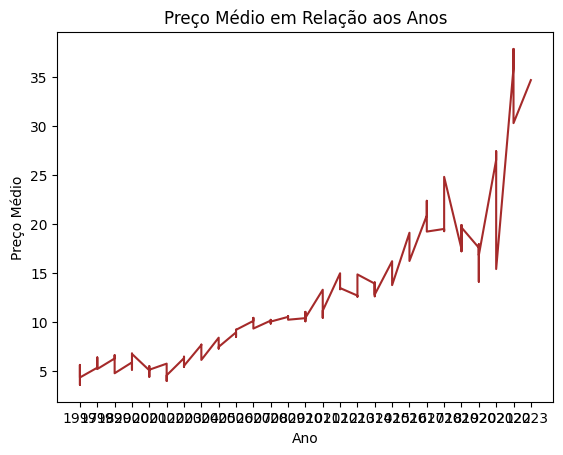

<Figure size 3000x2000 with 0 Axes>

In [ ]:
anos_ordenados = df_sorted_by_year.select("ano").rdd.flatMap(lambda x: x).collect()
precos_ordenados = df_sorted_by_year.select("tradicional").rdd.flatMap(lambda x: x).collect()
df_plot = spark.createDataFrame(zip(anos_ordenados, precos_ordenados), ["ano", "tradicional"])
df_plot_pandas = df_plot.toPandas()
plt.plot(df_plot_pandas['ano'], df_plot_pandas['tradicional'], color='brown')
plt.title('Preço Médio em Relação aos Anos')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')
plt.figure(figsize=(30, 20))
plt.show()


In [ ]:
df_recorte1 = df.filter((col('ano') >= 2019) & (col('ano') <= 2023))

In [ ]:
df_recorte2 = df.filter((col('ano') >= 2009) & (col('ano') <= 2018))

In [ ]:
df_recorte1.show()

+-----------+---+----+
|tradicional|mes| ano|
+-----------+---+----+
|      34.64|jan|2023|
|       35.9|dez|2022|
|      37.82|nov|2022|
|      34.33|out|2022|
|      33.86|set|2022|
|      36.23|ago|2022|
|      32.99|jul|2022|
|      37.38|jun|2022|
|      33.13|mai|2022|
|      34.17|abr|2022|
|      35.36|mar|2022|
|      34.91|fev|2022|
|      30.25|jan|2022|
|      26.51|dez|2021|
|      27.38|nov|2021|
|      26.43|out|2021|
|      26.49|set|2021|
|       25.0|ago|2021|
|      20.43|jul|2021|
|      18.25|jun|2021|
+-----------+---+----+
only showing top 20 rows



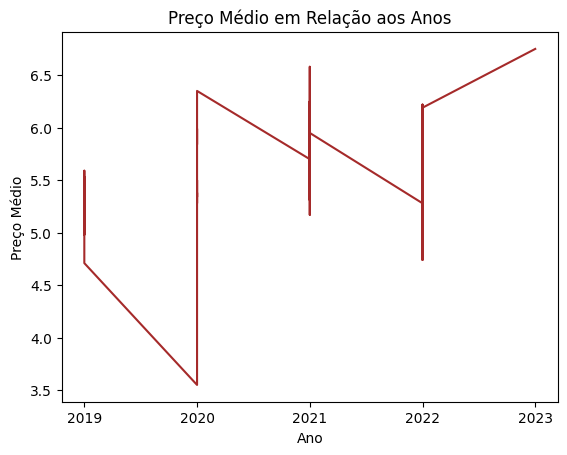

In [ ]:
anos_ordenados = df_recorte1.orderBy(F.asc("ano")).select("ano").rdd.flatMap(lambda x: x).collect()
precos_ordenados = df_sorted_by_year.select("tradicional").rdd.flatMap(lambda x: x).collect()
df_plot = spark.createDataFrame(zip(anos_ordenados, precos_ordenados), ["ano", "tradicional"])
df_plot_pandas = df_plot.toPandas()
plt.plot(df_plot_pandas['ano'], df_plot_pandas['tradicional'], color='brown')
plt.title('Preço Médio em Relação aos Anos')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')
plt.show()

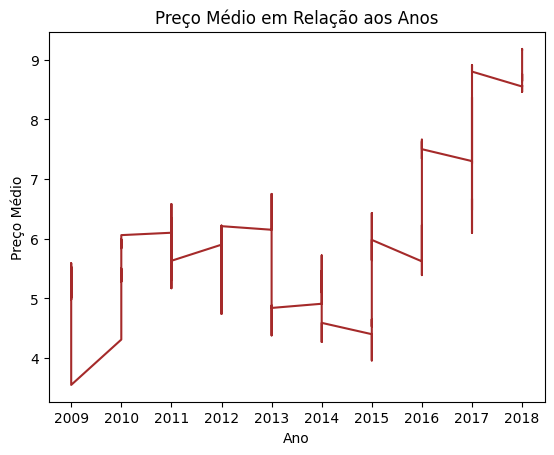

<Figure size 2000x600 with 0 Axes>

In [ ]:
anos_ordenados = df_recorte2.orderBy(F.asc("ano")).select("ano").rdd.flatMap(lambda x: x).collect()
precos_ordenados = df_sorted_by_year.select("tradicional").rdd.flatMap(lambda x: x).collect()
df_plot = spark.createDataFrame(zip(anos_ordenados, precos_ordenados), ["ano", "tradicional"])
df_plot_pandas = df_plot.toPandas()
plt.plot(df_plot_pandas['ano'], df_plot_pandas['tradicional'], color='brown')
plt.title('Preço Médio em Relação aos Anos')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')
plt.figure(figsize=(20, 6))
plt.show()

In [ ]:
df.tail(100)

[Row(tradicional=9.17, mes='jan', ano='2006'),
 Row(tradicional=8.37, mes='jul', ano='2005'),
 Row(tradicional=8.08, mes='mar', ano='2005'),
 Row(tradicional=7.26, mes='fev', ano='2005'),
 Row(tradicional=7.43, mes='jan', ano='2005'),
 Row(tradicional=7.63, mes='dez', ano='2004'),
 Row(tradicional=7.34, mes='nov', ano='2004'),
 Row(tradicional=7.53, mes='out', ano='2004'),
 Row(tradicional=7.66, mes='set', ano='2004'),
 Row(tradicional=7.51, mes='ago', ano='2004'),
 Row(tradicional=7.5, mes='jul', ano='2004'),
 Row(tradicional=7.3, mes='jun', ano='2004'),
 Row(tradicional=7.18, mes='mai', ano='2004'),
 Row(tradicional=6.76, mes='abr', ano='2004'),
 Row(tradicional=6.48, mes='mar', ano='2004'),
 Row(tradicional=6.67, mes='fev', ano='2004'),
 Row(tradicional=6.1, mes='jan', ano='2004'),
 Row(tradicional=6.28, mes='dez', ano='2003'),
 Row(tradicional=6.43, mes='nov', ano='2003'),
 Row(tradicional=6.24, mes='out', ano='2003'),
 Row(tradicional=5.66, mes='set', ano='2003'),
 Row(tradicional

In [ ]:
df_pandas = df.toPandas()

In [ ]:
df_pandas.to_csv('gs://comercio-cafe/TRATADOS/ABIC/preco_varejo_trat.csv', index=False)

In [ ]:
df_pandas.tail(100)

,tradicional,mes,ano
193,9.17,jan,2006
194,8.37,jul,2005
195,8.08,mar,2005
196,7.26,fev,2005
197,7.43,jan,2005
...,...,...,...
288,5.18,mai,1997
289,5.50,abr,1997
290,4.71,mar,1997
291,3.55,fev,1997


##Ministério da Cultura

In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/Ministério do Turismo/tratados.csv', sep=',', encoding='UTF-8')
ft_cafeterias = df.loc[df.tipo == 'Cafeteria']

In [ ]:
ft_cafeterias

In [ ]:
data_atual = datetime.now()
df['data_abertura'] = pd.to_datetime(df['data_abertura'], format='%Y/%m/%d')

In [ ]:
ft_cafeterias['idade'] = (data_atual - df['data_abertura']).dt.days / 365.25
ft_cafeterias['idade'] = ft_cafeterias['idade'].astype(int)

In [ ]:
ft_cafeterias[ft_cafeterias['nome_fantasia'].str.contains('SERRA')]

,cnpj,nome_fantasia,sit_cadastral,sit_atividade,tipo_estabecimento,nat_juridica,porte,uf,minicipio,data_abertura,cnaes,end_comercial,val_certificado,tipo,especialidade,idiomas,idade
201,03.921.524/0001-03,CONVENIÊNCIA VALE DA SERRA,Regular,Operação,Matriz,Empresário (Individual),EMPRESA DE PEQUENO PORTE,MT,Barra do Garças,2000-07-07,5611201,Marechal Rondon Barra do Garças Setor Cidade ...,2023-05-24,Cafeteria,Brasileira,-,22
6829,13.996.456/0001-03,CAFE DA SERRA,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,SC,Bom Retiro,2011-07-22,5611203,AV MAJOR GENEROSO 580 Bom Retiro,2022-08-26,Cafeteria,Brasileira,Português,11
8137,03.797.763/0001-01,CEDROS HOTEL DE SERRA,Regular,Operação,Matriz,Empresário (Individual),MICROEMPRESA,CE,Guaramiranga,2000-04-18,5590699|5611201|5611203|8230001|8230001,Rua Cel Batista de Queiroz 340 @cedrospousad...,2022-12-15,Cafeteria,Cozinha regional,-,23
12344,34.808.149/0001-13,CAFE SANTA SERRA,Regular,Operação,Matriz,Empresário Individual,MICROEMPRESA,SP,Serra Negra,2019-09-09,8230001|5611203|7990200|5611204,Est Municipal Jose Renato Pulini Marchi - Siti...,2023-04-22,Cafeteria,Brasileira,-,3
15507,28.688.999/0001-22,CHOCOLATERIA DA SERRA,Regular,Operação,Matriz,Sociedade Empresária Limitada,EMPRESA DE PEQUENO PORTE,SP,-,2017-09-20,5611203,Doutor Luis Felippe França Ramos 3000 Mairipor...,2023-07-22,Cafeteria,Brasileira,-,5
17458,12.880.172/0001-86,PANIFICADORA ENCOSTAS DA SERRA,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,SC,Santa Rosa de Lima,2010-11-16,5611203,RUA GERMANO HERMES MEYER N° 279 Santa Rosa d...,2023-09-28,Cafeteria,Alemã,-,12
18174,14.766.051/0001-33,PARANAIBA SERRA VERDE,Regular,Operação,Matriz,Sociedade Empresária Limitada,DEMAIS,MG,Belo Horizonte,2011-12-13,5611203,Leontino Francisco Alves 439 Belo Horizonte Se...,2023-04-11,Cafeteria,Brasileira,Português,11
19251,04.876.870/0001-80,SERRA AZUL,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,BA,Uruçuca,2001-04-12,5510801|5611201,R das Flores 244 Uruçuca,2024-07-02,Cafeteria,Brasileira,-,22


In [ ]:
ft_cafeterias

,cnpj,nome_fantasia,sit_cadastral,sit_atividade,tipo_estabecimento,nat_juridica,porte,uf,minicipio,data_abertura,cnaes,end_comercial,val_certificado,tipo,especialidade,idiomas,idade
15,17.287.526/0001-05,BRASIL VEXADO,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,EMPRESA DE PEQUENO PORTE,DF,Brasília,2012-10-12,5611201,EQSD 1/13 3025 Brasília Taguatinga Sul (Taguat...,2023-08-31,Cafeteria,Brasileira,Espanhol,10
16,14.314.724/0001-14,FRAN'S CAFÉ,Regular,Operação,Matriz,Sociedade Empresária Limitada,EMPRESA DE PEQUENO PORTE,DF,Brasília,2011-09-14,5620102|5611201|5611203|5611204,CLSW 302 Bloco C Brasília Setor Sudoeste CEP:...,2023-12-13,Cafeteria,Americana,Inglês,11
67,25.276.829/0001-42,*****,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,DF,Brasília,2016-07-25,5611203,EPTG EQ 2/3 Brasília Quadras Econômicas Lúcio...,2023-05-21,Cafeteria,Brasileira,-,6
71,13.497.202/0001-32,CIOCOLATERIA,Regular,Operação,Matriz,Empresa Individual de Responsabilidade Limitad...,EMPRESA DE PEQUENO PORTE,DF,Brasília,2011-06-04,5611203,CLS 410 Bloco A Loja 13 Brasília Asa Sul CEP: ...,2023-02-17,Cafeteria,Francesa,Inglês,11
73,07.644.005/0001-04,EMPADA BRASIL,Regular,Operação,Matriz,Sociedade Empresária Limitada,EMPRESA DE PEQUENO PORTE,DF,Brasília,2005-10-13,5611203,SHIS QI 5 Bloco J Brasília Setor de Habitaçõe...,2023-09-12,Cafeteria,Brasileira,-,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20235,29.635.810/0001-04,RICOS DA TIJUCA,Regular,Operação,Matriz,Sociedade Empresária Limitada,MICROEMPRESA,RJ,Rio de Janeiro,1985-08-30,5611203,General Roca - até 230/231 Rio de Janeiro Tiju...,2024-03-30,Cafeteria,Brasileira|Portuguesa,-,37
20258,38.250.190/0001-78,WAKU-WAKU COFFEE,Regular,Operação,Matriz,Sociedade Empresária Limitada,EMPRESA DE PEQUENO PORTE,SP,São Paulo,2020-08-27,8230001|8230002|8230002|8230001|4789001|562010...,Maria Antônia São Paulo Vila Buarque CEP: 012...,2024-03-30,Cafeteria,Brasileira,-,2
20335,31.010.847/0006-95,Curta Café,Regular,Operação,Filial,Sociedade Empresária Limitada,DEMAIS,RS,Gramado,2021-10-13,5611201,borges de medeiros 2659 Gramado,2024-03-31,Cafeteria,Cozinha regional|Brasileira|Alemã,-,1
20347,32.148.093/0002-73,DI FERREIRA CHOCOLATES E CIA,Regular,Operação,Filial,Sociedade Empresária Limitada,MICROEMPRESA,SP,Guarulhos,2020-11-25,5611203,Hélio Smidt Guarulhos Aeroporto CEP: 07190100 SP,2024-03-30,Cafeteria,Brasileira,-,2


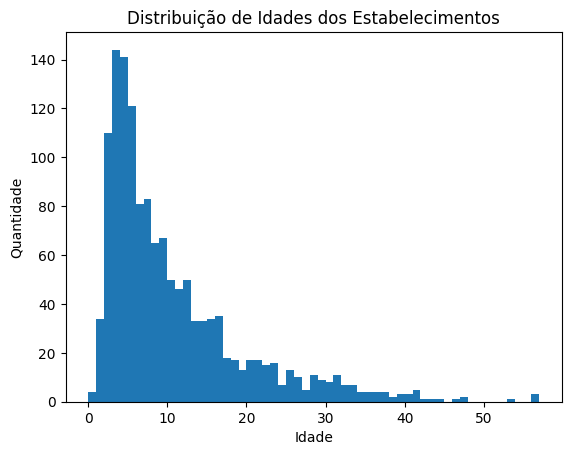

In [ ]:
# Histograma com as idades
plt.hist(ft_cafeterias['idade'], bins=range(min(ft_cafeterias['idade']), max(ft_cafeterias['idade']) + 2, 1))

# configurando o título e os rótulos
plt.title('Distribuição de Idades dos Estabelecimentos')
plt.xlabel('Idade')
plt.ylabel('Quantidade')

plt.show()

In [ ]:
ft_cafeterias_bahianas = ft_cafeterias[ft_cafeterias['uf'].str.contains('BA')]

In [ ]:
ft_cafeterias[ft_cafeterias['end_comercial'].str.contains('BA')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 3386 to 18075
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cnpj                21 non-null     object
 1   nome_fantasia       21 non-null     object
 2   sit_cadastral       21 non-null     object
 3   sit_atividade       21 non-null     object
 4   tipo_estabecimento  21 non-null     object
 5   nat_juridica        21 non-null     object
 6   porte               21 non-null     object
 7   uf                  21 non-null     object
 8   minicipio           21 non-null     object
 9   data_abertura       21 non-null     object
 10  cnaes               21 non-null     object
 11  end_comercial       21 non-null     object
 12  val_certificado     21 non-null     object
 13  tipo                21 non-null     object
 14  especialidade       21 non-null     object
 15  idiomas             21 non-null     object
 16  idade               21

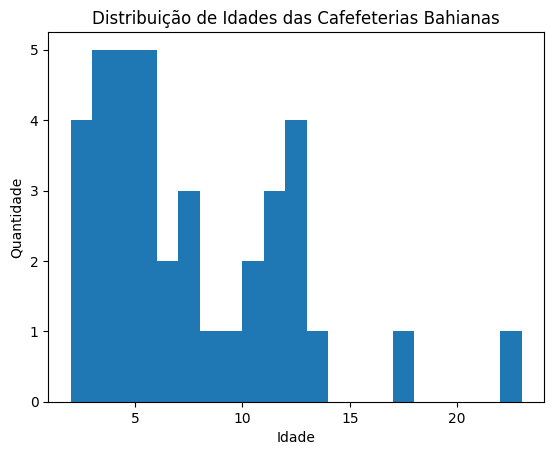

In [ ]:
# Histograma com as idades
plt.hist(ft_cafeterias_bahianas['idade'], bins=range(min(ft_cafeterias_bahianas['idade']), max(ft_cafeterias_bahianas['idade']) + 2, 1))

# configurando o título e os rótulos
plt.title('Distribuição de Idades das Cafefeterias Bahianas')
plt.xlabel('Idade')
plt.ylabel('Quantidade')

plt.show()

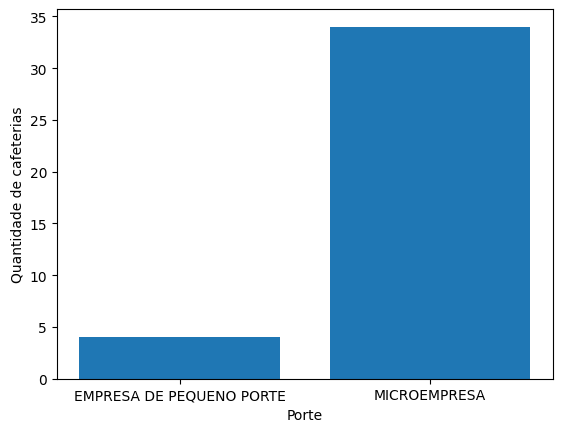

In [ ]:
df_por_porte = ft_cafeterias_bahianas.groupby('porte').size().reset_index(name='quantidade')

# Plotar o gráfico de barras
plt.bar(df_por_porte['porte'], df_por_porte['quantidade'])
plt.xlabel('Porte')
plt.ylabel('Quantidade de cafeterias')
plt.show()

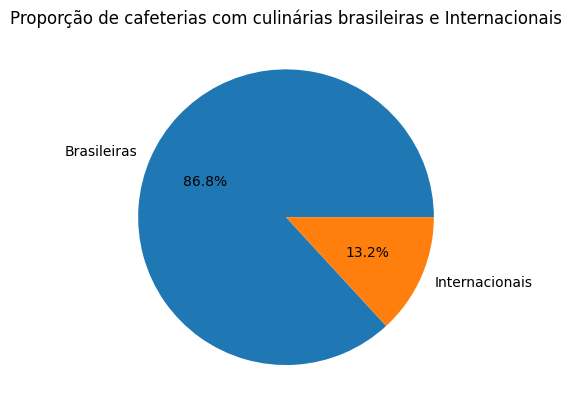

In [ ]:
brasileiras = ft_cafeterias_bahianas['especialidade'].str.contains('brasileira', case=False).sum()
Internacional = len(ft_cafeterias_bahianas) - brasileiras

# Cria o gráfico de pizza
fig, ax = plt.subplots()
ax.pie([brasileiras, Internacional], labels=['Brasileiras', 'Internacionais'], autopct='%1.1f%%')
ax.set_title('Proporção de cafeterias com culinárias brasileiras e Internacionais')

plt.show()

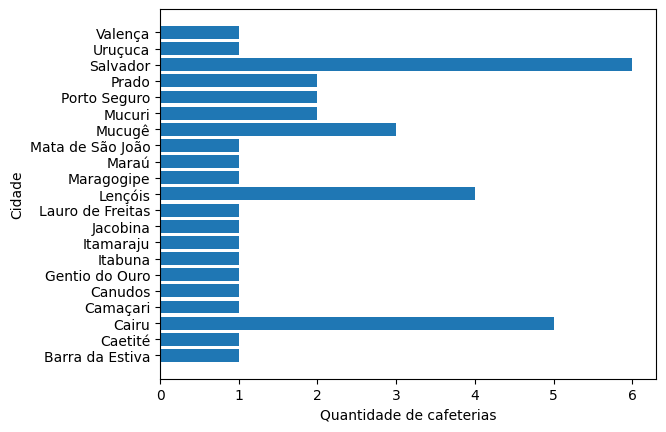

In [ ]:
df_por_municipio = ft_cafeterias_bahianas.groupby('minicipio').size().reset_index(name='quantidade')

# Plotar o gráfico de barras
plt.barh(df_por_municipio['minicipio'], df_por_municipio['quantidade'])
plt.xlabel('Quantidade de cafeterias')
plt.ylabel('Cidade')
plt.show()

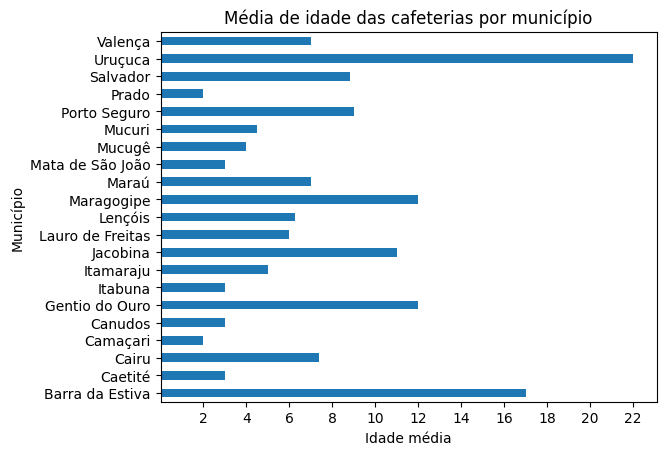

In [ ]:
# Calcula a média de idade por município
media_idade_por_municipio = ft_cafeterias_bahianas.groupby('minicipio')['idade'].mean()

# Plota o gráfico de barras horizontal
media_idade_por_municipio.plot.barh()
plt.xlabel('Idade média')
plt.ylabel('Município')
plt.xticks(range(min(ft_cafeterias_bahianas['idade']), max(ft_cafeterias_bahianas['idade']) + 1, 2))
plt.title('Média de idade das cafeterias por município')

plt.show()

In [ ]:
ft_cafeterias_bahianas.loc[ft_cafeterias_bahianas['idade'] == 6]

,cnpj,nome_fantasia,sit_cadastral,sit_atividade,tipo_estabecimento,nat_juridica,porte,uf,minicipio,data_abertura,cnaes,end_comercial,val_certificado,tipo,especialidade,idiomas,idade
7523,25.011.151/0001-76,A BAIANINHA CAFE BISTRO,Regular,Operação,Matriz,Empresário Individual,MICROEMPRESA,BA,Lauro de Freitas,2016-06-15,5611203|4789001,Praia de Itapoan Quadra 15 Lote 37 Lauro de F...,2022-08-10,Cafeteria,Brasileira,Inglês|Espanhol,6
12708,24.839.280/0001-94,AUE VESTUARIO,Regular,Operação,Matriz,Empresário (Individual),MICROEMPRESA,BA,Porto Seguro,2016-05-19,4789001|5510801|5510802|5611201|7990200|823000...,av navegantes 56 Caraiva,2023-03-05,Cafeteria,Brasileira,-,6


##ABIC

In [ ]:
df_produtores = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/10_maiores_produtores.csv', sep=',', encoding='UTF-8')

In [ ]:
df_produtores

,classificacao,uf,empresa,ano
0,1,SP,SARA LEE CAFES DO BRASIL LTDA.,2009
1,2,CE,SANTA CLARA IND. E COM. DE ALIMENTOS S/A.,2009
2,3,SP,MELITTA DO BRASIL IND. E COM. LTDA.,2009
3,4,SE,INDS. ALIMENTS. MARATA LTDA.,2009
4,5,SP,CIA. CACIQUE DE CAFE SOLUVEL,2009
...,...,...,...,...
105,6,PB,SAO BRAZ S_A IND. E COM. DE ALIMENTOS S.A,2022
106,7,MG,CAMIL ALIMENTOS S.A.,2022
107,8,SP,MASSIMO ZANETTI BEVERAGE BRASIL LTDA,2022
108,9,GO,CAFE RANCHEIRO AGRO INDL. LTDA.,2022


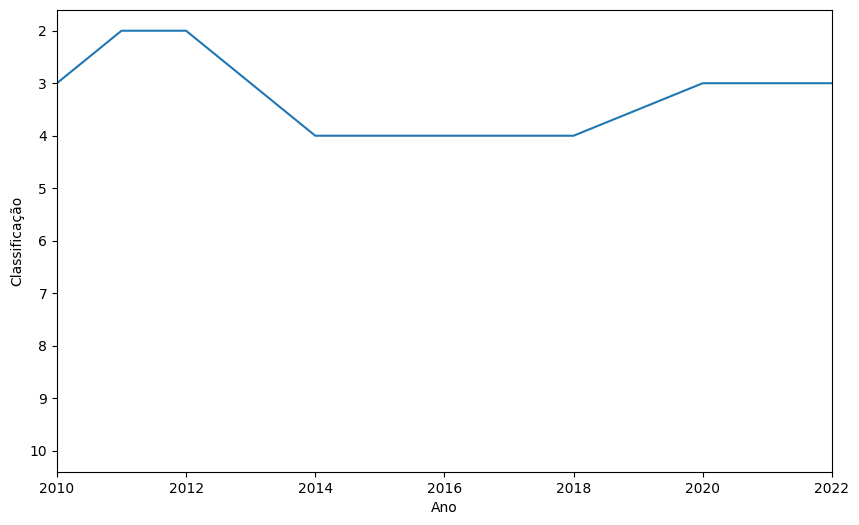

In [ ]:
# Selecionando apenas os dados da empresa
empresa_a = df_produtores[df_produtores['empresa'] == 'MELITTA DO BRASIL IND. E COM. LTDA.']

# Configurando o plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(2010, 2022)
ax.set_xlabel('Ano')
ax.set_ylabel('Classificação')
ax.invert_yaxis()

# Plotando
ax.plot(empresa_a['ano'], empresa_a['classificacao']+ 0, 10)

# Mostrando o plot
plt.show()

In [ ]:
# Filtrar os dados com classificação igual a 1
ft_class_1 = df_produtores[df_produtores['classificacao'] == 1]

contagem = ft_class_1['empresa'].value_counts()

print("O produtor que mais esteve na classificação 1 é:", contagem.idxmax())

O produtor que mais esteve na classificação 1 é: GRUPO TRES CORACOES


In [ ]:
df = pd.read_csv('gs://comercio-cafe/TRATADOS/ABIC/consumo_interno.csv', sep=',', encoding='UTF-8')

In [ ]:
df

,categoria,ano_anterior,ano_atual,crescimento,ano
0,Empresas associadas,10580000.0,11140000.0,5.22,2008
1,Empresas não-associadas,3589000.0,3589000.0,NaN,2008
2,Total de empresas cadastradas,14170000.0,14720000.0,3.88,2008
3,Consumo não cadastrado,1953000.0,1953000.0,NaN,2008
4,Total geral de café torrado e moído,16130000.0,16680000.0,3.41,2008
...,...,...,...,...,...
41,Empresas de café solúvel (1),1079930.0,1079930.0,NaN,2014
42,Total nacional de consumo de café,20085640.0,20333790.0,"-1,231",2014
43,Consumo per-capita: café em grão cru,608.0,611.0,NaN,2014
44,Consumo per-capita: café torrado e moído,487.0,489.0,NaN,2014
